# **TP Wavelets**

In this TP, we will work on some fundamental concepts in Wavelets and compression of images.

First we'll briefly check the limitations of the Fourier transform. We'll then check some fundamental properties of a family of Wavelets and compute the Wavelet transform of a very simple signal. In the second part of the TP, we will use the DWT to compress and image.

Make sure to sequentially run all the cells in each section, so that the intermediate variables / packages will carry over to the next cell

We recommend you save a copy of this colab in your drive so you don't lose progress!

**Note 1:** As mentioned in the course and since there's not any policy regarding ChatGPT at Télécom level yet, you can use it. However, using ChatGPT without understanding their outputs is not OK, and will be penalized accordingly in your grade. Please be sure of all the functions you'll use.

**Note 2:** Several points have associated questions. When answering these questions, all responses should be properly justified. ChatGPT answers are very easy to spot.

**Note 3:** Always plot the functions and outputs you're generating. If the output or function is not properly plotted/shown, this will reduce points in your grade.

# Setup
First, we install PyWavelets

In [39]:
!pip install PyWavelets

In [40]:
import pywt

pywt.__version__

'1.4.1'

# Important
Google Colab is an interesting tool to try things out quickly. However, Google Colab and more general Notebooks are not meant to be an Integrated Development Environment (IDE). For a real job, please use an actual IDE like PyCharm or VS Code.

# Limitation of the Fourier Transform
*   Create a sinusoidal signal of 2.5 seconds of duration.
*   Set up a sampling rate of 20kHz. The signal should be divided in 5 parts of 0.5 seconds of duration each.
*  The signal should have the following frequencies in this order {10 Hz, 30 Hz, 60 Hz, 30 Hz, 10 Hz}.

In [41]:
import numpy as np
Fs = 20e3;
time = np.arange(0,2.5,1/Fs)
freq_array = np.array([10,30,60,30,10])
signal = np.zeros(len(time))
for i in range(len(freq_array)):
    signal[i*int(len(time)/len(freq_array)):(i+1)*int(len(time)/len(freq_array))] = np.sin(2*np.pi*freq_array[i]*time[i*int(len(time)/len(freq_array)):(i+1)*int(len(time)/len(freq_array))])

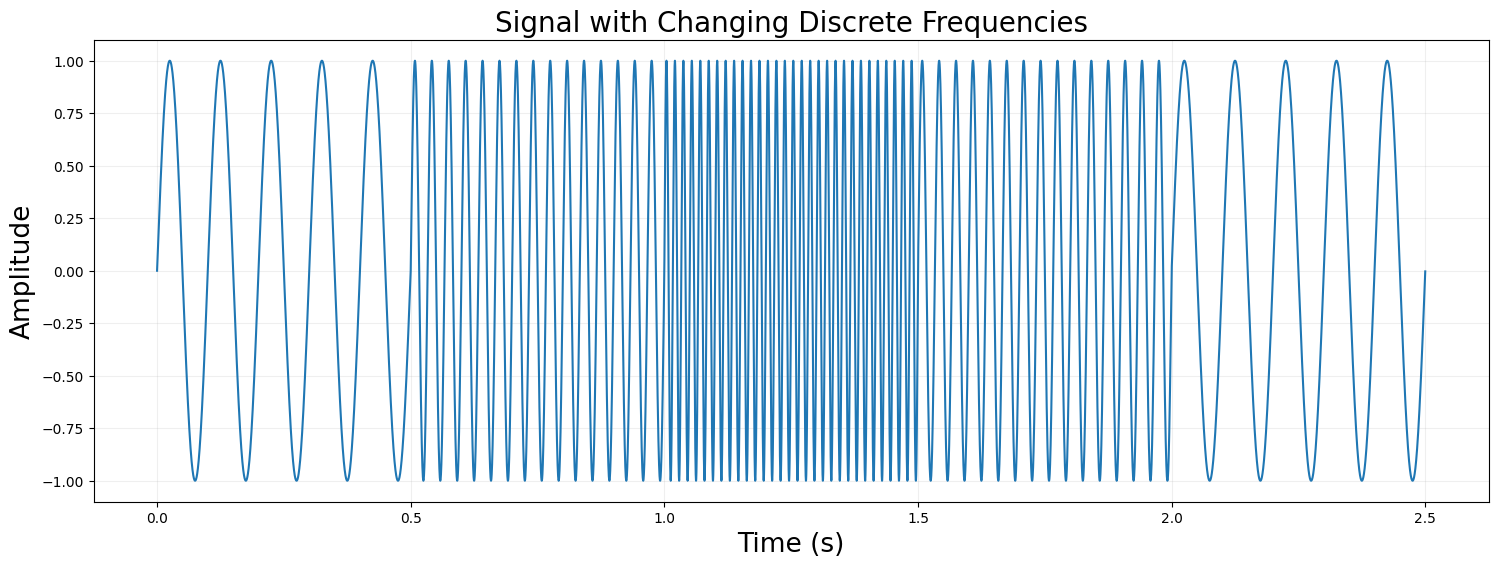

In [42]:
import matplotlib
import matplotlib.pyplot as plt

font_size = 20

plt.figure(figsize=(18, 6))

plt.plot(time, signal, linewidth=1.5)
plt.title('Signal with Changing Discrete Frequencies', fontsize=font_size)
plt.xlabel('Time (s)', fontsize=font_size-1)
plt.ylabel('Amplitude', fontsize=font_size-1)
plt.grid(alpha=0.2)

Now, you should compute the Discrete Fourier Transform of the signal. You can use any library from Python you prefer. You might need to cut the x-axis in the Fourier transform up to 100 Hz in the visualization. Please check https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html and https://numpy.org/doc/stable/reference/generated/numpy.fft.fftfreq.html

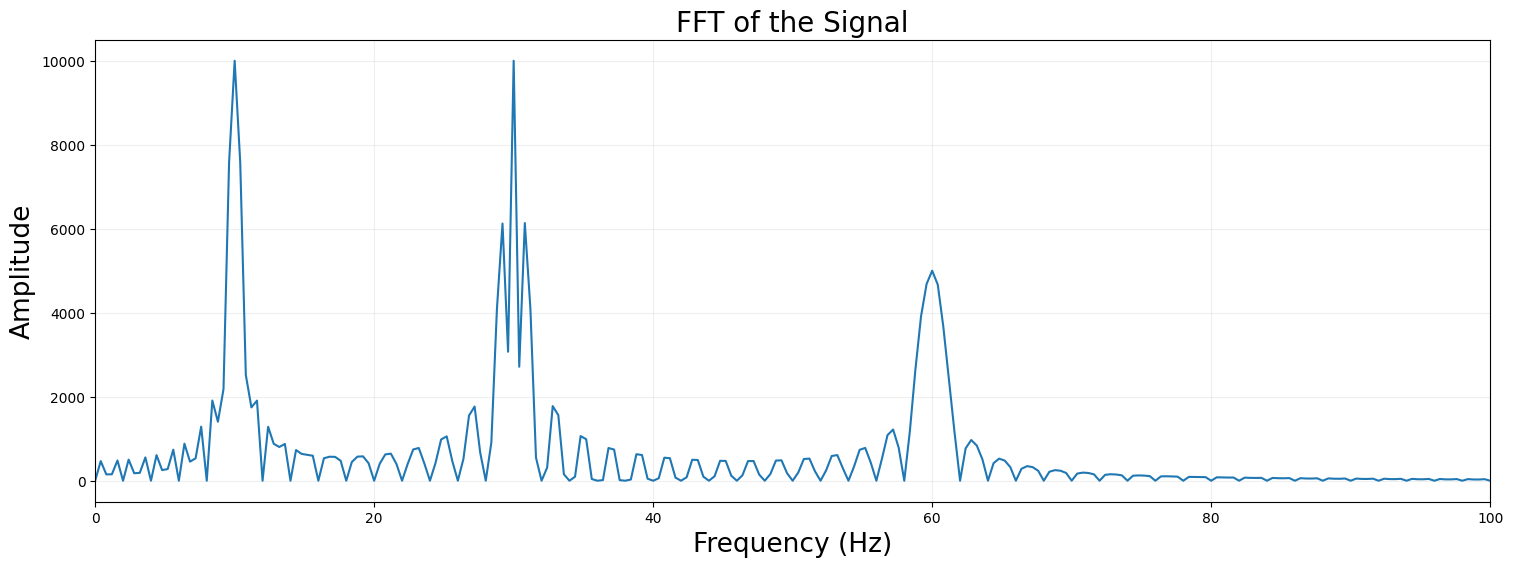

In [43]:
# calculate the FFT of this signal
from scipy.fft import fft
Amplitude = np.abs(fft(signal))
freq = np.linspace(0, Fs, len(Amplitude))

# plot the FFT
plt.figure(figsize=(18, 6))
plt.plot(freq, Amplitude, linewidth=1.5)
plt.title('FFT of the Signal', fontsize=font_size)
plt.xlabel('Frequency (Hz)', fontsize=font_size-1)
plt.ylabel('Amplitude', fontsize=font_size-1)
plt.xlim([0,100])
plt.grid(alpha=0.2)
plt.show()

**QUESTIONS**

1) Does the established sampling rate satisfy the Nyquist-Shannon sampling theorem to avoid aliasing? Please justify.

2) What can you say from the signal looking **only** at the Fourier transform?

3) Can you be certain about the location of some frequency component in the time domain? Why?

**YOUR ANSWERS HERE:**

1) Satisfy. Because the largest frequency in this signal is 60 Hz, which is less that half of the Nyquist-Shannon sampling frequency 10 kHz.

2) There are three main frequencies, which are 10 Hz, 20 Hz and 30 Hz and the energy of the last is the half of the others. But it also includes some "noise", which can see between the three peaks.

3) No. Because from the graphy of the FFT, it has no relation with time.

# **Mother Wavelet**
As we saw in the course, a wavelet is not just a function but a whole family of functions that satisfy certain requirements. In this part of the TP we're gonna work with the Morlet wavelet defined as follows: $\Psi(t)=k e^{iw_0t}e^{-\frac{1}{2}(\frac{t}{\sigma})^2}$. Please generate a Morlet wavelet in Python **WITHOUT using PyWavelets** with the following parameters:

-Center frequency of the wavelet = 10 Hz

-Sampling rate $\eta$ = 20000 Hz

-$k=\frac{1}{\sqrt{\eta}}$

-$\sigma = 0.1$

You can generate the wavelet between -1 and 1 seconds, so the time duration of the wavelet is 2 seconds. For this part, you just need to generate the real part of the wavelet.

Text(0, 0.5, 'Amplitude')

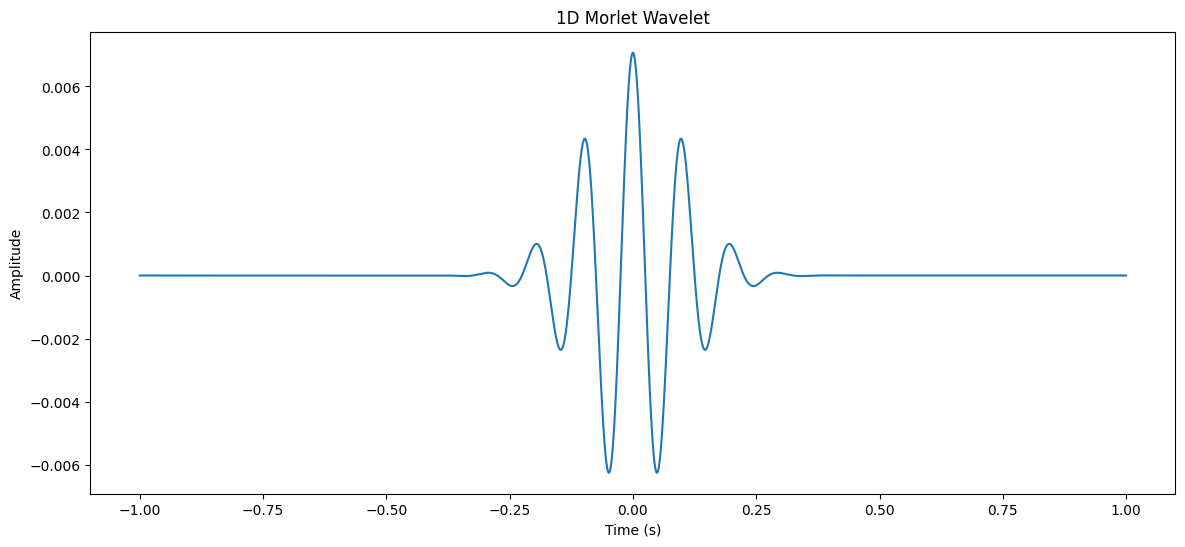

In [44]:
ita = 20000
time_Psi = np.arange(-1,1,1/ita)
omega0 = 2*np.pi*10
k = 1/np.sqrt(ita)
sigma = 0.1
Psi = k*np.exp(1j*omega0*time_Psi)*np.exp(-1/2*(time_Psi/sigma)**2)

# Plot the real part of the Morlet wavelet in 1D
plt.figure(figsize=(14, 6))

plt.plot(time_Psi, np.real(Psi), linewidth=1.5)
plt.title('1D Morlet Wavelet')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

Please show that the mother wavelet we just created satisfies the admissibility and the finite energy conditions:

In [45]:
# show the mother wavelet is admissible
absolut_sum = np.sum(Psi)
# show the mother wavelet is satisfied finite energy
square_sum = np.sum(np.abs(Psi)**2)
print('The absolute sum of the wavelet is: ', absolut_sum)
print('The square sum of the wavelet is: ', square_sum)

The absolute sum of the wavelet is:  (9.483649011280895e-08-9.727855414703056e-16j)
The square sum of the wavelet is:  0.1772453850905711


**Note:** In real life, you have to deal with finite-precision related problems. Therefore, if for the admissibility condition you don't have exactly the value you were expecting for, don't worry.

# **Convolution**

As we saw in the course, we need a measure of similarity to compute the wavelet transform. We also saw that we can easily compute the shift in time and similarity calculation with the 1-D convolutions.

* Generate a chirp sinusoidal signal from -5 to 5 seconds with an initial frequency of 5 Hz and final frequency of 15 Hz and sampling rate of 20kHz:

Text(0.5, 0, 'Time')

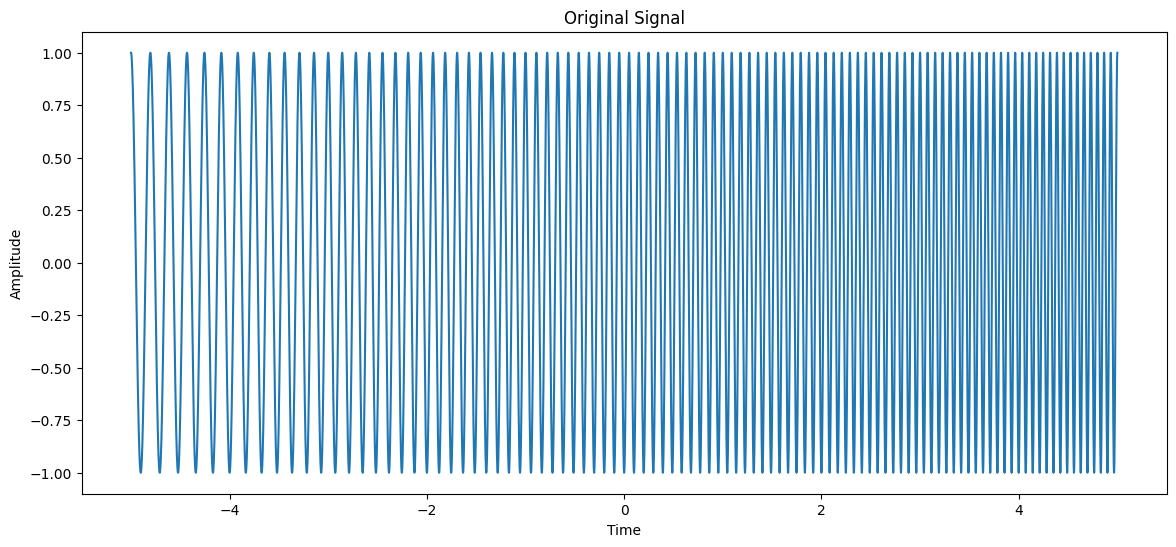

In [46]:
import scipy.signal as ss
start_freq = 5
end_freq = 15
Fs = 20000

# Generate the chirp signal
time_signal = np.linspace(0, 10, 10*Fs)
signal = ss.chirp(time_signal, f0=start_freq, f1=end_freq, t1=10, method='linear')
time_signal = np.arange(-5,5,1/Fs)


plt.figure(figsize=(14, 6))
plt.plot(time_signal, signal)
plt.title('Original Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time')

Now create a Morlet wavelet with the following parameters:

* Center frequency of the wavelet = 10 Hz

* Sampling rate $\eta$ = 20000 Hz

* $k=\frac{1}{\sqrt{\eta}}$
* $\sigma = 0.2$

Text(0.5, 0, 'Time')

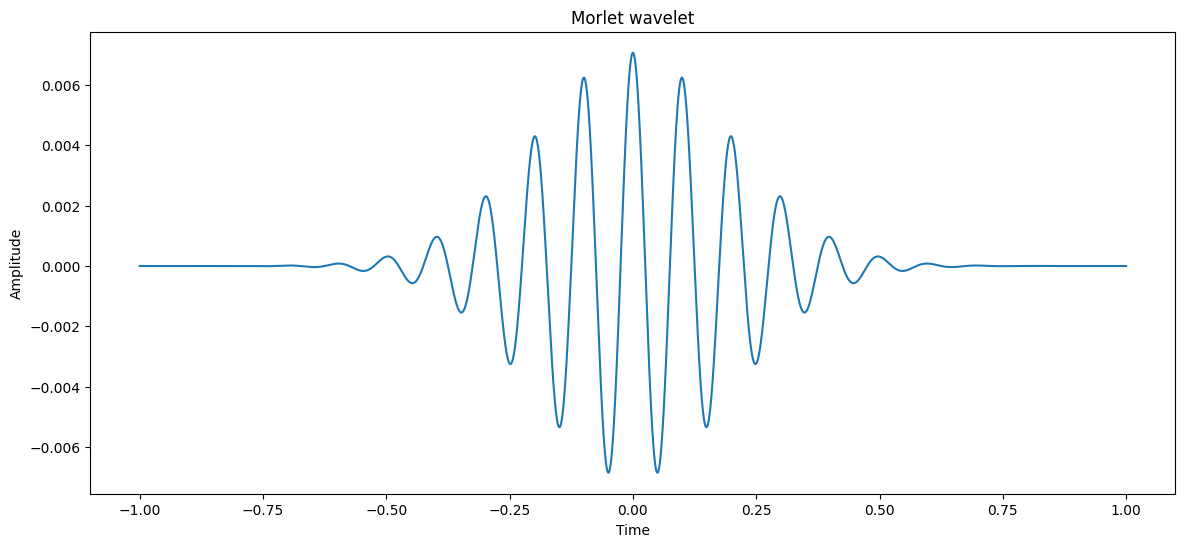

In [47]:
ita = 20000
time = np.arange(-1,1,1/ita)
omega0 = 2*np.pi*10
k = 1/np.sqrt(ita)
sigma = 0.2
morlet_wavelet = k*np.exp(1j*omega0*time_Psi)*np.exp(-1/2*(time_Psi/sigma)**2)

plt.figure(figsize=(14, 6))
plt.plot(time, np.real(morlet_wavelet))
plt.title('Morlet wavelet')
plt.ylabel('Amplitude')
plt.xlabel('Time')

Compute the convolution between the Morlet wavelet and $Re(\Psi(t))$. For reference on how to perform convolution with scipy 'convolve' function, please check https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html

Text(0, 0.5, 'Amplitude')

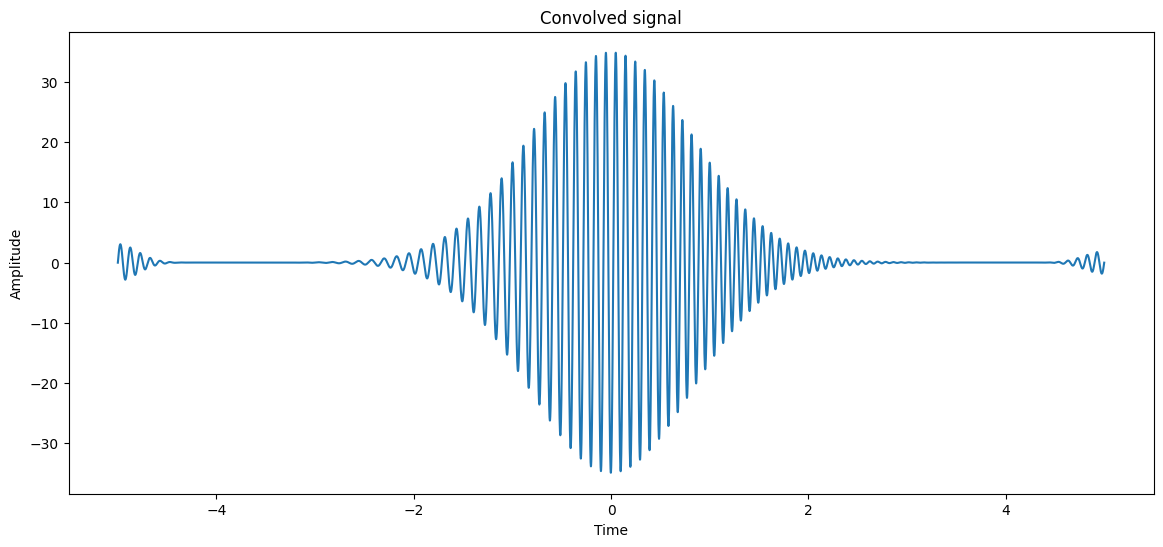

In [48]:
import scipy.signal as ss

convolved_signal = ss.convolve(signal, np.real(morlet_wavelet), mode='same')

plt.figure(figsize=(14, 6))
plt.plot(time_signal, convolved_signal)
plt.title('Convolved signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

There are some points where the convolution is zero, even in regions of high similarity between the wavelet and the signal. **Is this OK?** If it's not, propose a solution to that.

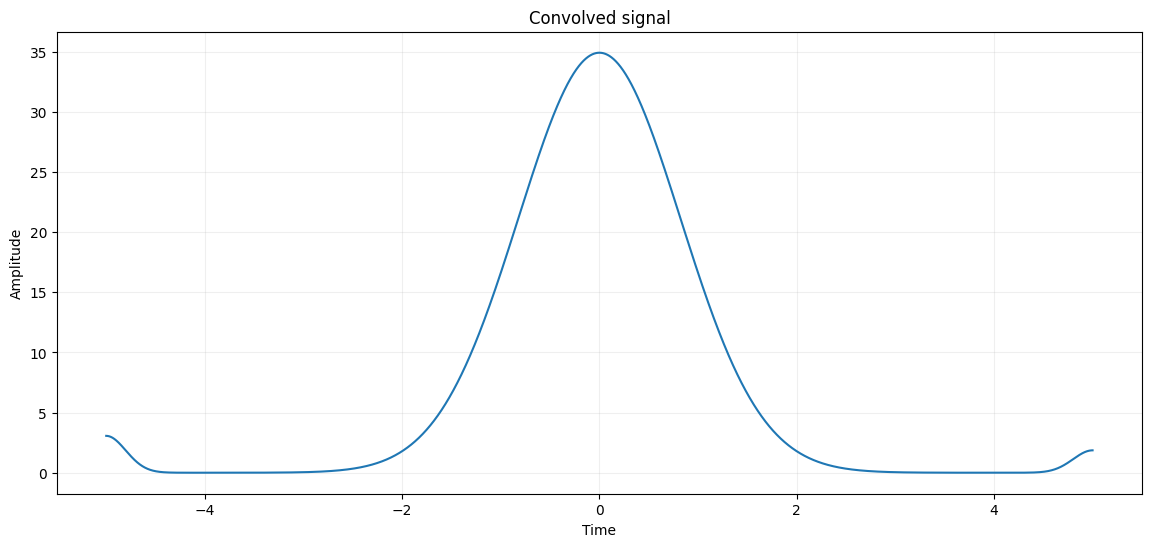

In [49]:
signal = signal + 0j
convolved_signal = ss.convolve(signal, morlet_wavelet, mode='same',method='direct')

plt.figure(figsize=(14, 6))
plt.plot(time_signal, np.abs(convolved_signal))
plt.title('Convolved signal')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.grid(alpha=0.2)

# **Image Compression**
For this part, we'll use the Discrete Wavelet Transform (DWT) implemented as a filter bank to do image compression. The first step is to have an image to compress. For doing so you can use the following piece of code to download an image of Trudy.

In [50]:
# !wget https://raw.githubusercontent.com/jhonygiraldo/jhonygiraldo.github.io/main/Trudy_for_compression.jpeg

**Visualize image:** With the following code you can visualize the image. If you're using Google Collab, most probably you already have the open cv library installed. If you're using Jupyter Notebook for example, you'll have to install open cv if it's not already installed.

In [51]:
# Let us define a function for visualizing images
def show_image(image, title='Input Image', font_size=12,fig_size = (10, 10)):
  #A function that uses matplotlib to show grayscale images
  plt.figure(figsize=fig_size)
  plt.imshow(image, cmap='gray')
  plt.title(title, fontsize=font_size)
  plt.axis('off')

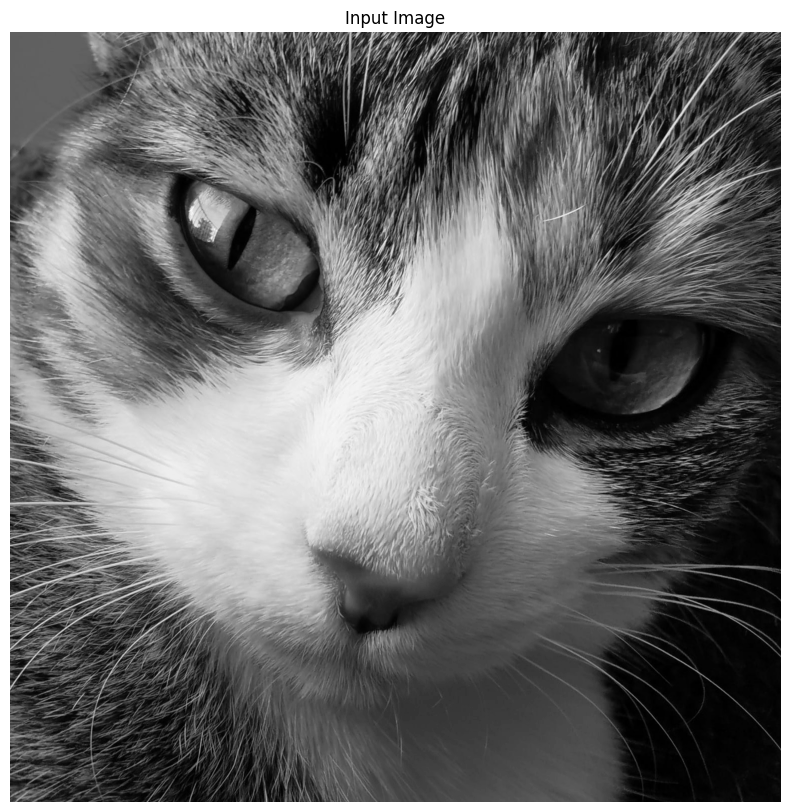

In [52]:
import cv2

# Load your image as a grayscale
input_image = cv2.imread('Trudy_for_compression.jpeg', cv2.IMREAD_GRAYSCALE)
# Display the original image
show_image(input_image, 'Input Image')

If you use some wavelet function (Biorthogonal 1.3 in this case), the 1-level 2D wavelet decomposition of our input image is given as follows:

In [53]:
# # You can see a list of wavelet families
import pywt
pywt.families()

['haar',
 'db',
 'sym',
 'coif',
 'bior',
 'rbio',
 'dmey',
 'gaus',
 'mexh',
 'morl',
 'cgau',
 'shan',
 'fbsp',
 'cmor']

In [54]:
# For each family, you can list the available wavelets
pywt.wavelist(family='bior', kind='all')

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8']

In the previous image we applied a threshold in the wavelet coefficients for visualization purposes. **Please explain the meaning of each of these 4 images**.

**YOUR ANSWER HERE:**

Top left picture is the gray picture of after low pass filter. These three are pictures after high pass filter.

Bottom left picture is the output of vertical filter. Top right picture is the output of horizontal filter. Bottom right pictures are the output of diagonatical filter.

Now, you should compute the six-levels 2D wavelet decomposition of the input image with a Daubechies wavelet with six vanishing moments using the PyWavelet library. Please check https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html#d-multilevel-decomposition-using-wavedec2

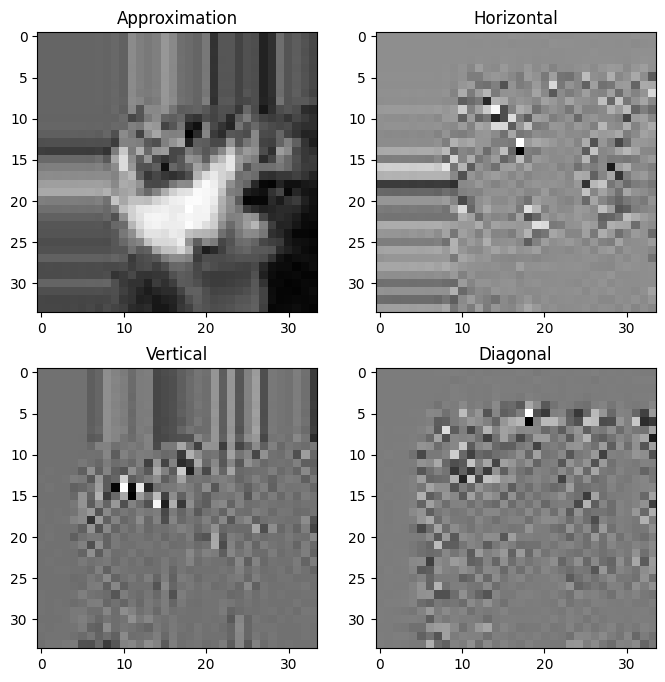

In [55]:
level = 6
wavelet = 'db6'
coeffs = pywt.wavedec2(input_image, wavelet=wavelet, level=level)

cA2, (cH2, cV2, cD2), *rest = coeffs

plt.figure(figsize=(8, 8))
plt.subplot(2,2,1)
plt.imshow(cA2, cmap='gray')
plt.title('Approximation')
plt.subplot(2,2,2)
plt.imshow(cH2, cmap='gray')
plt.title('Horizontal')
plt.subplot(2,2,3)
plt.imshow(cV2, cmap='gray')
plt.title('Vertical')
plt.subplot(2,2,4)
plt.imshow(cD2, cmap='gray')
plt.title('Diagonal')
plt.show()


* Set a threshold of value of 100 and take to zero the values less than that in the 2D wavelet decomposition. **Note:** You should only threshold the outputs of the high-pass filters.



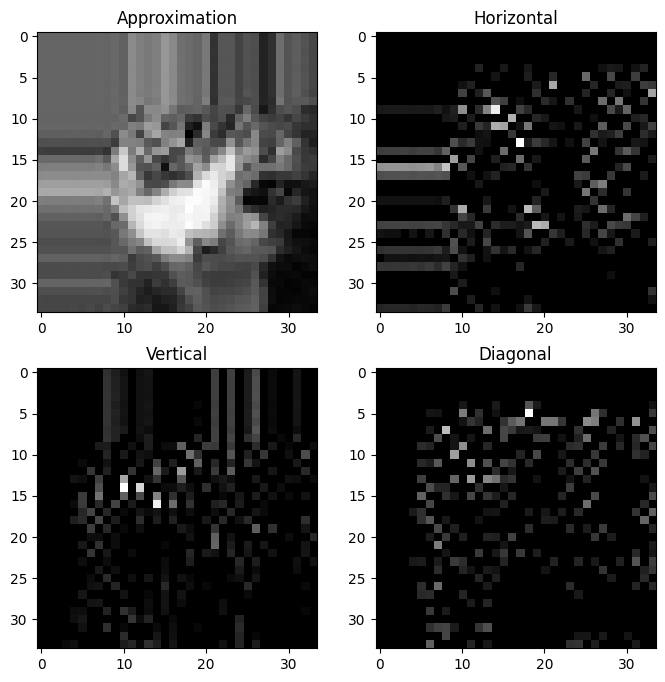

In [56]:
threshold = 100

cH2[cH2 <threshold] = 0
cV2[cV2 <threshold] = 0
cD2[cD2 <threshold] = 0

plt.figure(figsize=(8, 8))
plt.subplot(2,2,1)
plt.imshow(cA2, cmap='gray')
plt.title('Approximation')
plt.subplot(2,2,2)
plt.imshow(cH2, cmap='gray')
plt.title('Horizontal')
plt.subplot(2,2,3)
plt.imshow(cV2, cmap='gray')
plt.title('Vertical')
plt.subplot(2,2,4)
plt.imshow(cD2, cmap='gray')
plt.title('Diagonal')
plt.show()


* Compute the IDWT to reconstruct the image after the "compression". Check https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html#d-multilevel-reconstruction-using-waverec2 as a reference.

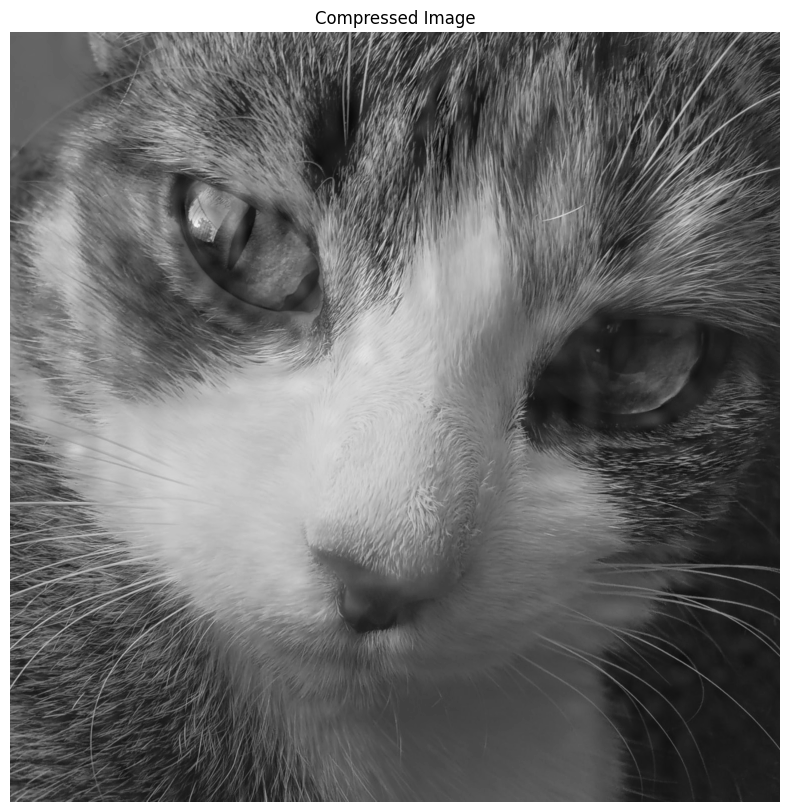

In [57]:
thr_coeffs = (cA2, (cH2, cV2, cD2), *rest)
compressed_image = pywt.waverec2(thr_coeffs, wavelet)

show_image(compressed_image, 'Compressed Image')

What's the compression ratio?

In [58]:
original_size = input_image.nbytes  
compressed_size = compressed_image.nbytes  
compression_ratio = original_size / compressed_size
display(compression_ratio)

0.12491840731070496

# **Putting everything together**

In this exercise we'll analyze the Peak Signal to Noise Ration (PSNR) of the compressed images for different thresholds. For doing so, we'll give you the function to compute the PSNR between the original and compressed image.

In [59]:
def calculate_psnr(original_image, compressed_image):
    h,w = original_image.shape
    mse = np.sum(np.abs(original_image-compressed_image)**2)/(h*w)
    return 20* np.log10(255**2/mse)

Now, you have to create a function codec that receives the input image, the wavelet to be used, the number of levels, and the threshold value. This function returns the compressed image and the compression ratio. **Note:** You already did that previously.

In [60]:
def image_compression(input_image,wavelet='db4',num_levels=6,threshold=100):
  coeffs = pywt.wavedec2(input_image, wavelet=wavelet, level=num_levels)
  cA2, (cH2, cV2, cD2), *rest = coeffs
  cH2[cH2 <threshold] = 0
  cV2[cV2 <threshold] = 0
  cD2[cD2 <threshold] = 0
  thr_coeffs = (cA2, (cH2, cV2, cD2), *rest)
  compressed_image = pywt.waverec2(thr_coeffs, wavelet)
  original_size = input_image.nbytes  
  compressed_size = compressed_image.nbytes  
  compression_ratio = original_size / compressed_size
  return compressed_image , compression_ratio 

Now, we compare the performance of the 'db4' and the 'bior1.3' wavelets in terms of compression ratio and PSNR for different thresholds.

In [61]:
wavelets = ['db4', 'bior1.3']
thresholds = [5,10,20,40,80,100]
num_levels=6

for wavelet in wavelets:
    for threshold in thresholds:
        compressed_image , compression_ratio = image_compression(input_image, wavelet, num_levels, threshold)
        psnr_value = calculate_psnr(input_image, compressed_image[:-1, :])
        # show psnr and compression ratio
        print('wavelet = ',wavelet, ',thr = ', threshold, ',PSNR = ',psnr_value, ',compression ratio = ', compression_ratio)


wavelet =  db4 ,thr =  5 ,PSNR =  60.71349333655078 ,compression ratio =  0.12491840731070496
wavelet =  db4 ,thr =  10 ,PSNR =  60.71329393790709 ,compression ratio =  0.12491840731070496
wavelet =  db4 ,thr =  20 ,PSNR =  60.71279830410431 ,compression ratio =  0.12491840731070496
wavelet =  db4 ,thr =  40 ,PSNR =  60.70883365216964 ,compression ratio =  0.12491840731070496
wavelet =  db4 ,thr =  80 ,PSNR =  60.679102829253424 ,compression ratio =  0.12491840731070496
wavelet =  db4 ,thr =  100 ,PSNR =  60.65617464751603 ,compression ratio =  0.12491840731070496
wavelet =  bior1.3 ,thr =  5 ,PSNR =  53.1948452559707 ,compression ratio =  0.12491840731070496
wavelet =  bior1.3 ,thr =  10 ,PSNR =  53.19475081545128 ,compression ratio =  0.12491840731070496
wavelet =  bior1.3 ,thr =  20 ,PSNR =  53.19462231773666 ,compression ratio =  0.12491840731070496
wavelet =  bior1.3 ,thr =  40 ,PSNR =  53.19323810072306 ,compression ratio =  0.12491840731070496
wavelet =  bior1.3 ,thr =  80 ,PSNR

**QUESTIONS**

1) Which wavelet is better for the Trudy_for_compression.jpeg image and why?

It is better to use wavelet db4, because the compression ratio is nearly same between db4 and bior1.3, while the PSNR for db4 is higher than bior1.3.

# Supplementary Exercises (Optional)
1. Designing and using custom filters with the pyWavelets library
Reference (https://pywavelets.readthedocs.io/en/latest/ref/wavelets.html#wavelet-families)
2. Propose and explore custom wavelets that achieve equivalent or higher compression ratio on the Trudy image explored previously. **P.S** You are free to explore any approach here.